In [1]:
!pip install -q torchviz

In [2]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
import pickle, json
import pandas as pd
from torchsummary import summary
from torchviz import make_dot
from google.colab import drive
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.optim import Adam, AdamW
import torchvision
import torchvision.transforms as transforms
import pickle
import torch

In [3]:
# To ensure reproducibility
random.seed(11)
np.random.seed(11)

# To connect to google drive
# drive.mount('/content/drive')

In [4]:
# Check if cuda available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device being ran on:", device)

Device being ran on: cuda


In [5]:
# For avoiding retraining if saved
saved = False

# Preprocessing the data

In [6]:
# Load the dataset
path = '/kaggle/input/a3-dataset-noaug/'
# path = '/content/drive/MyDrive/Colab Notebooks/ECSE551-A3/'
with open(path + 'Train.pkl', 'rb') as f:
    train_x = pickle.load(f, encoding ='bytes')
with open(path + 'Test.pkl', 'rb') as f:
    test_x = pickle.load(f, encoding='bytes')


train_y = pd.read_csv(path + 'Train_labels.csv', header=None, encoding='latin1').values #new encoding given error?

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')


# Train validation split
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# Squeeze for NumPy
x_train = x_train.squeeze()
x_val = x_val.squeeze()
x_test = test_x.squeeze()


print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)


(48000, 28, 28)
(48000, 1)
(12000, 28, 28)
(12000, 1)
(10000, 28, 28)


## Augmentation & Normalization
Augementation is a process we use to help increase performance by training the CNN to identify random variations in the training set!
Normalization increases our performance by restricting the dataset to abide by a certain range of values

In [7]:
augment = False

In [8]:
# Transform the data and normalize it
test_transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
])

if augment:
    transformer = transforms.Compose([
        transforms.ToTensor(),                   # convert to tensor and scale to [0, 1]
        transforms.RandomAffine(
            degrees=0,              # no rotation
            translate=(0.1, 0.1),   # width and height shift range = 10%
        ),
        transforms.RandomHorizontalFlip(p=0.5),  # default is 0.5
        transforms.Normalize((0.5,), (0.5,))     # mimic rescale by centering and scaling
    ])
else:
  # Transform the data and normalize it
    transformer = test_transformer

# Convert our data to PyTorch
train_x_torch = torch.stack([transformer(img) for img in x_train]).to(device)
train_y_torch = torch.tensor(y_train).to(device)
val_x_torch = torch.stack([transformer(img) for img in x_val]).to(device)
val_y_torch = torch.tensor(y_val).to(device)

test_x_torch = torch.stack([test_transformer(img) for img in x_test]).to(device)


# Move to device
print(train_x_torch.shape)
print(train_y_torch.shape)
print(val_x_torch.shape)
print(val_y_torch.shape)
print(test_x_torch.shape)


# Create our dataset
train_data = torch.utils.data.TensorDataset(train_x_torch, train_y_torch)
test_data = torch.utils.data.TensorDataset(test_x_torch)
val_data = torch.utils.data.TensorDataset(val_x_torch, val_y_torch)



torch.Size([48000, 1, 28, 28])
torch.Size([48000, 1])
torch.Size([12000, 1, 28, 28])
torch.Size([12000, 1])
torch.Size([10000, 1, 28, 28])


## Visualize some of the data

(10, 28, 28)


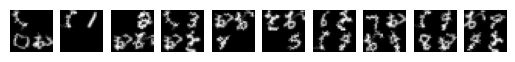

0.9882352948188782 0.0


In [9]:
# Visualize 10 random images
import random
import matplotlib.pyplot as plt

# Put aside an array for the patterns
patterns = np.zeros((10,28,28))

# Set aside one image per class to store (10 images in total)
for category in range(10):
  inclass = [i for i in range(y_train.shape[0]) if y_train[i] == category]
  patterns[category,:] = x_train[inclass[random.randint(0,len(inclass))],:]


print(patterns.shape)

#Plot the patterns we're going to store
fig, axs = plt.subplots(1,10)
for c in range(10):
    axs[c].imshow(patterns[c,:], cmap='gray')
    axs[c].axis("off")
plt.show()

# check the max and min pixel value
print(patterns[0,:].max(), patterns[0,:].min())



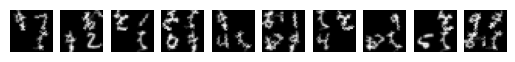

In [10]:
# Print test images
fig, axs = plt.subplots(1,10)
for c in range(10):
    axs[c].imshow(test_x[c,:].squeeze(), cmap='gray')
    axs[c].axis("off")
plt.show()

# Train, Validate & Test the CNN
Before implementing our architectures, we set up a framework for training our neural networls. Our neural networks will be trained using the training set and the validation set will help us to determine when to stop training so that we don't overfit. We then plot our findings and identify the best epoch range. Then based on our best findings we output the CSV file using the test function.

## Train & Validate

In [11]:
saved = False

In [12]:
# Create a train function
def train(net, trainset, valset, criterion, optimizer, epochs, size=32):
    val_losses = []
    train_losses = []
    val_accuracies = []
    train_accuracies = []
    counter = 0
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=size,
                                         shuffle=True, num_workers=0)
    train_size = len(trainloader)
    for epoch in range(epochs):  # loop over the dataset multiple times
      running_loss = 0.0
      correct_images = 0
      total_images = 0
      # iterate through batches
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          # Move inputs and labels to the same device as the model for GPU use
          inputs = inputs.to(device).type(torch.float32) # Cast inputs to float32

          labels = labels.to(device).type(torch.long) # Cast labels to long
          labels = labels.squeeze()

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)

          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # compute statistics
          running_loss += loss.item()

          # compute accuracy
          predicted_label = torch.argmax(outputs, axis=1)
          correct_images += torch.sum(predicted_label == labels)

          total_images += len(labels)

      # Let's do validation
      valloader = torch.utils.data.DataLoader(val_data, batch_size=size,
                                         shuffle=True, num_workers=0)
      val_loss = 0.0
      val_correct_images = 0
      val_total_images = 0

      # We don't want gradient or weight updates when validating
      with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # Move inputs and labels to the same device as the model for GPU use
            labels = labels.squeeze()

            inputs = inputs.to(device).type(torch.float32) # Cast inputs to float32

            labels = labels.to(device).type(torch.long) # Cast labels to long

            # forward + backward + optimize
            outputs = net(inputs)

            loss = criterion(outputs, labels)

            # compute statistics
            val_loss += loss.item()

            # compute accuracy
            predicted_label = torch.argmax(outputs, axis=1)
            val_correct_images += torch.sum(predicted_label == labels)
            val_total_images += len(labels)

      # Track data
      train_losses.append(running_loss/train_size)
      val_losses.append(val_loss/len(valloader))
      train_accuracies.append((correct_images/total_images).item())
      val_accuracies.append((val_correct_images/val_total_images).item())
      if epoch > 2:
          if val_accuracies[-1] - val_accuracies[-2] <= 0.001:
              counter = counter + 1
              if counter == 4:
                  print('Early stop at epoch: ', epoch)
                  break
    return train_losses, val_losses, train_accuracies, val_accuracies

## Testing CNN

Finally, we will save the output with the optimized Neural Network hyperparameters.
We found that the following parameters provide the best results based on validation accuracy.



In [13]:
def test(network, testset, batch_size, filename, noise=True):
    # (Each Batch has 32 Predictions)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
    # Record true values
    y_pred = torch.zeros(10000)
    network.eval()
    with torch.no_grad(): # We disable weight updates
        for i, data in enumerate(testloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            if noise:
                inputs = data
            else:
                inputs = data[0]
            test_images = inputs.to(device)

            # Get the probabilities
            outputs = network(test_images)

            # Update predictions
            start_index = i * batch_size
            finish_index = start_index + inputs.shape[0]
            y_pred[start_index: finish_index] = torch.argmax(outputs, axis=1)


    image_ids = np.arange(1, 10001)

    # Remove last 12 items from perediction

    # Save image_ids y_pred as a csv file with two columns
    df = pd.DataFrame(
        {'id': image_ids,
        'class': y_pred.cpu().numpy().astype(int)}
        )
    df.to_csv(filename + '.csv', index=False)

    return y_pred

## Plotting Loss & Accuracy

In [14]:
# Given the accyracy, losses of validation and training plot them all
def plot_loss_acc(train_losses, val_losses, train_accuracies, val_accuracies):
  fig, axs = plt.subplots(1,2)
  axs[0].plot(train_losses, label='Training Loss')
  axs[0].plot(val_losses, label='Validation Loss')
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Loss')
  axs[0].legend()

  axs[1].plot(train_accuracies, label='Training Accuracy')
  axs[1].plot(val_accuracies, label='Validation Accuracy')
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Accuracy')
  axs[1].legend()

  plt.show()

# Convolutional Neural Networks

## AlexNet
AlexNet is a classic convolutional neural network originally designed for high-resolution RGB images (224×224×3) in the ImageNet challenge. It consists of stacked convolutional layers with large kernels, max pooling, and fully connected layers at the end.

However, for datasets like MNIST, which contains grayscale images of size 28×28, the original AlexNet is overkill and incompatible due to:

The original AlexNet has 8 layers (5 Convolutional, 3 FC) layers and that's because it needs that level of complexity however this implementation will use 5 layers (3 Convolutional, 2 FC) because having the original kernel sizes and filters didnt make sense as an 11x11 filter would be detrimental on the performance of 28x28 images. Additionally, the pooling layers were an overkill so we reduce these. However what the AlexNet does is that it used Convolution, BatchNorm, ReLu, Pooling and then FC layers and so we use that as an inspiration.

This lightweight version retains the AlexNet flavor but is optimized for small, simple images.
https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

In [15]:
class AlexNetwork(nn.Module):
      def __init__(self, function):
          super(AlexNetwork, self).__init__()
          # 1 input channel, outputs 32 kernels, size 3x3
          self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
          self.bn1 = nn.BatchNorm2d(32)

          # 32 input channels, outputs 64 kernels, size 3x3
          self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
          self.bn2 = nn.BatchNorm2d(64)

          # Pooling layer
          self.pool = nn.MaxPool2d(2,2)

          # 64, 128 channels,
          self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
          self.bn3 = nn.BatchNorm2d(128)

          # First FC layer
          self.fc1 = nn.Linear(128*3*3, 256)
          # MNIST digit classification
          self.fc2 = nn.Linear(256, 10)

          # Activation function
          self.activation = function

      def forward(self, x,):
          # 32, 28, 28
          x = self.activation(self.bn1(self.conv1(x)))        # → (batch, 32, 28, 28)
          # 64, 14, 14
          x = self.pool(self.activation(self.bn2(self.conv2(x))))  # → (batch, 64, 14, 14)
          # 128, 7, 7
          x = self.pool(self.activation(self.bn3(self.conv3(x))))  # → (batch, 128, 7, 7)
          # 128, 3, 3
          x = self.pool(x)
          # Flattening to 1152
          x = x.view(-1, 128 * 3 * 3)

          x = self.activation(self.fc1(x))
          x = self.fc2(x)

          return x

Let's visualize our Neural Network (The code below was generated using the help of GitHub Copilot)

In [16]:
# Instantiate the model
alex_net = AlexNetwork(function=F.relu)

# Move the model to the GPU if available
alex_net = alex_net.to(device)


## LeNet
https://medium.com/@siddheshb008/lenet-5-architecture-explained-3b559cb2d52b

LeNet-5, The original architecture consists of:

	•	2 convolutional layers (with average pooling)

	•	Followed by 3 fully connected layers

	•	Uses tanh activation functions throughout

LeNet was designed to be computationally lightweight and demonstrated the potential of deep learning in image recognition tasks, especially for grayscale images of size 28×28.


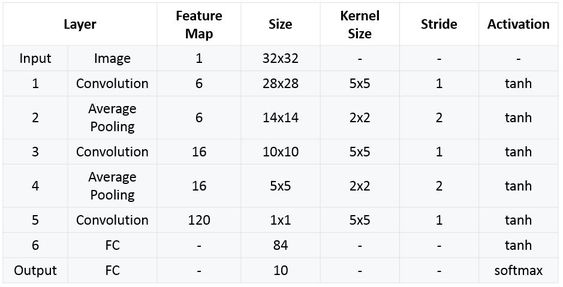

We have to make some modifications to the original network as we want to improve it's performance. The original paper had a 32x32 image as input and so changes must be made to accomodate that. Additionally since this is an old paper, it is now more common to use ReLu as an activation function rather than tanh so we will test that out too.

Our dataset also is not a traditional MNIST dataset, so we need more convolution layers and smaller kernel sizes to capture more details. Additionally the original network used average pooling we will instead use max pooling as it can select features better. We also will also support regularization and normalization as we have seen in class that they usually improve performance

We do this by changing it by convolving twice every single block and using max pooling instead

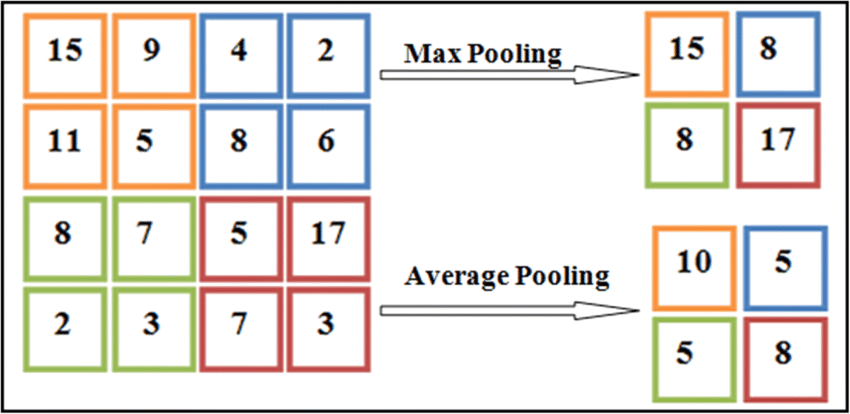

We aim with our new implementation is to do the following

- **Improved Feature Extraction:**
  - More convolutional layers and channels allow for learning more complex and abstract representations.
  
- **Enhanced Training Stability:**
  - Batch Normalization after each convolution layer helps stabilize training and accelerates convergence.
  
- **Regularization:**
  - Dropout before the fully connected layers helps mitigate overfitting by randomly deactivating neurons during training.



In [17]:
import torch.nn as nn

class LeNet6(nn.Module):
    def __init__(self, function, num_classes=10):
        super(LeNet6, self).__init__()
        self.activation = function

        # Block 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Block 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)

        # Block 3
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)

        # Pooling and Dropout
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Block 1
        x = self.activation(self.conv1(x))
        x = self.bn1(x)
        x = self.activation(self.conv2(x))
        x = self.bn2(x)
        x = self.pool(x)

        # Block 2
        x = self.activation(self.conv3(x))
        x = self.bn3(x)
        x = self.activation(self.conv4(x))
        x = self.bn4(x)
        x = self.pool(x)

        # Block 3
        x = self.activation(self.conv5(x))
        x = self.bn5(x)
        x = self.activation(self.conv6(x))
        x = self.bn6(x)
        x = self.pool(x)

        # Flatten
        x = x.view(-1, 128 * 3 * 3)

        # Fully connected layers
        x = self.dropout(x)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)

        return x

The modified architecture enhances the original LeNet by introducing deeper convolutional layers  with batch normalization to ensure good training. Two max pooling operations effectively downsample the feature maps while preserving key features, and a dropout layer with a 50% rate is incorporated before the fully connected layers to not risk overfitting. The fully connected section is expanded into three layers 625, 84, and 10 units so that we finally reach the 10 digit classification task.

## Resnet

ResNet18 is one of the smaller variants in the ResNet family. It consists of 18 layers, and is much faster and lighter than deeper versions like ResNet50 or ResNet101 — while still being powerful enough for many tasks like MNIST, CIFAR-10, or medical image classification.
Inspired by: https://github.com/marrrcin/pytorch-resnet-mnist/blob/master/pytorch-resnet-mnist.ipynb

	•   Lightweight: Small enough to train quickly, even on a modest GPU

	•	Powerful: Benefits from residual connections, enabling better gradient flow and accuracy

	•	Pre-built: Available directly from torchvision.models with optional pretrained weights

	•	Proven: Widely used for benchmarks and real-world tasks


In [18]:
# Our implementation
from torchvision.models import resnet18

class ResNetwork(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNetwork, self).__init__()

        self.model = resnet18(num_classes=10)

        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2),
                                     padding=(3, 3), bias=False)
    def forward(self, x):
      return self.model(x)


# GAN (Generative Adversarial Network)

A **GAN (Generative Adversarial Network)** is a type of neural network that consists of two competing models:

**Pix2Pix** is a type of **Conditional Generative Adversarial Network (cGAN)** designed for **image-to-image translation** tasks.

It works by learning a mapping from **input images** (e.g., noisy MNIST digits) to **output images** (e.g., clean MNIST digits), using paired data.

How it works:

- **Generator**: Learns to map a noisy image to a clean image.
- **Discriminator**: Tries to tell the difference between real clean images and ones generated by the Generator.
- The Generator is trained to **fool the Discriminator** while producing realistic, denoised images.


Pix2Pix uses a combination of:
- **Adversarial Loss** (GAN loss): Makes outputs look realistic.
- **L1 Loss** (Reconstruction loss): Ensures the output is close to the ground truth.

This setup trains a Generator to remove noise from images, making it perfect for handwriting or document restoration tasks.

Our problem here is that we can't match the noisy dataset to the MNIST since it's unordered so we have to create a custom dataset that allows us to do extract a an image from the original MNIST dataset that matches our label.

In [19]:
# Load pytorch MNIST dataset
from torchvision import datasets
from torch.utils.data import Dataset
import random
from collections import defaultdict

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=test_transformer)


class NoisyToCleanDataset(Dataset):
    def __init__(self, noisy_data, noisy_labels, clean_dataset):
        self.noisy_data = noisy_data
        self.noisy_labels = noisy_labels
        self.clean_dataset = clean_dataset
        self.label_to_indices = defaultdict(list)
        for idx, (_, label) in enumerate(clean_dataset):
            self.label_to_indices[label].append(idx)

    def __len__(self):
        return len(self.noisy_data)

    def __getitem__(self, idx):
        noisy = self.noisy_data[idx]
        label = self.noisy_labels[idx].item()

        # Random clean MNIST digit with the same label
        clean_idx = random.choice(self.label_to_indices[label])
        clean_img, _ = self.clean_dataset[clean_idx]
        

        return noisy, clean_img, label

# Our dataset
noisy_clean_dataset = NoisyToCleanDataset(
    noisy_data=train_x_torch,
    noisy_labels=train_y_torch,
    clean_dataset=train_data,
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.64MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 148kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.41MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.96MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



torch.Size([1, 28, 28]) torch.Size([1, 28, 28])


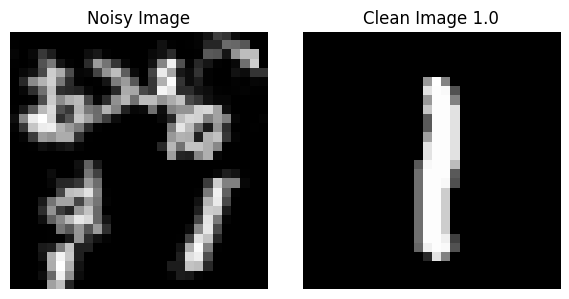

In [20]:
# Choose a sample to visualize
noisy_img, clean_img, label = noisy_clean_dataset[2]

print(noisy_img.shape, clean_img.shape)

# Plot side-by-side
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(noisy_img.squeeze().cpu(), cmap='gray')
plt.title("Noisy Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(clean_img.squeeze(), cmap='gray')
plt.title(f"Clean Image {label}")
plt.axis('off')

plt.tight_layout()
plt.show()

## Generator


In [21]:
# Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # Encoder part: noisy image -> latent representation
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Decoder part: latent representation -> clean image
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Discriminator

In [22]:
# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

## Training GAN

In [23]:
def train_gan(gen, disc, trainset, criterion1, criterion2, optimizer_d,
              optimizer_g, epochs, size=32, device='cuda'):
    train_losses = []
    # Loading our dataset
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=size,
                                              shuffle=True, num_workers=0)
    for epoch in range(epochs):
        gen.train()
        disc.train()
        running_d_loss = 0.0
        running_g_loss = 0.0
        
        for data in trainloader:
            noisy_imgs, clean_imgs, _ = data
            
            noisy_imgs = noisy_imgs.to(device).float()
            clean_imgs = clean_imgs.to(device).float()
            batch_size = noisy_imgs.size(0)
            
            valid = torch.full((batch_size, 1), 1.0, device=device)
            fake = torch.full((batch_size, 1), 0.0, device=device)
            
            # Train Discriminator
            optimizer_d.zero_grad()
            
            # Real loss - pass only clean images to discriminator
            real_preds = disc(clean_imgs)
            d_real_loss = criterion1(real_preds, valid)
            
            # Fake loss - generate fake images and pass to discriminator
            fake_imgs = gen(noisy_imgs).detach()  # detach to avoid training generator
            fake_preds = disc(fake_imgs)
            d_fake_loss = criterion1(fake_preds, fake)
            
            # Total Discriminator loss
            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            optimizer_d.step()
            
            #  Train Generator
            optimizer_g.zero_grad()
            
            gen_imgs = gen(noisy_imgs)
            # Pass only generated images to discriminator
            g_adv = criterion1(disc(gen_imgs), valid)
            g_recon = criterion2(gen_imgs, clean_imgs)
            
            # Balance between adversarial and reconstruction loss
            g_loss = 0.05 * g_adv + g_recon            
            g_loss.backward()
            optimizer_g.step()
            
            running_d_loss += d_loss.item()
            running_g_loss += g_loss.item()
            
        avg_d_loss = running_d_loss / len(trainloader)
        avg_g_loss = running_g_loss / len(trainloader)
        train_losses.append((avg_d_loss, avg_g_loss))
        
        print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {avg_d_loss:.4f} | G Loss: {avg_g_loss:.4f}")
        
        # Optional: Save intermediate models during training
        if (epoch + 1) % 10 == 0:
            torch.save(gen.state_dict(), f"generator_epoch_{epoch+1}.pth")
            
    return train_losses

In [24]:
gen = Generator().to(device)
disc = Discriminator().to(device)

criterion1 = nn.BCELoss()
criterion2 = nn.L1Loss()

# Add weight droput due to D becoming really powerful
optimizer_d = AdamW(disc.parameters(), lr=0.0001, betas=(0.5, 0.999), weight_decay=0.0001)
optimizer_g = AdamW(gen.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=0)

train_losses = train_gan(gen, disc, noisy_clean_dataset, criterion1, criterion2,
                         optimizer_d, optimizer_g, 10, size=32)

Epoch [1/10] | D Loss: 0.3794 | G Loss: 0.3918
Epoch [2/10] | D Loss: 0.2155 | G Loss: 0.4275
Epoch [3/10] | D Loss: 0.1280 | G Loss: 0.4576
Epoch [4/10] | D Loss: 0.0889 | G Loss: 0.4800
Epoch [5/10] | D Loss: 0.0646 | G Loss: 0.4973
Epoch [6/10] | D Loss: 0.0581 | G Loss: 0.5121
Epoch [7/10] | D Loss: 0.0469 | G Loss: 0.5248
Epoch [8/10] | D Loss: 0.0428 | G Loss: 0.5310
Epoch [9/10] | D Loss: 0.0346 | G Loss: 0.5435
Epoch [10/10] | D Loss: 0.0364 | G Loss: 0.5495


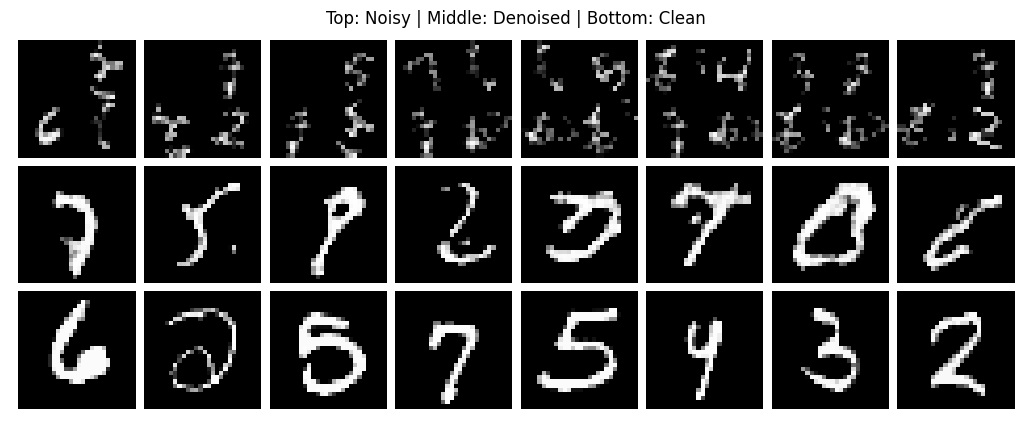

In [25]:
from torchvision.utils import make_grid, save_image

def visualize_denoising(gen, dataset, num_samples=8, save_path=None):
    gen.eval()
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=num_samples, shuffle=True)

    with torch.no_grad():
        noisy_imgs, clean_imgs, _ = next(iter(dataloader))
        noisy_imgs = noisy_imgs.to(device).float()
        clean_imgs = clean_imgs.to(device).float()
        denoised_imgs = gen(noisy_imgs)

    # Combine all images vertically (noisy, denoised, clean)
    all_imgs = torch.cat([noisy_imgs.cpu(), denoised_imgs.cpu(), clean_imgs.cpu()], dim=0)

    # Create a grid
    grid = make_grid(all_imgs, nrow=num_samples, pad_value=1)

    # Save if path is given
    if save_path:
        save_image(grid, save_path)
        print(f"Saved output to: {save_path}")

    return noisy_imgs.cpu(), denoised_imgs.cpu(), clean_imgs.cpu(), grid

noisy, denoised, clean, grid = visualize_denoising(gen, noisy_clean_dataset, num_samples=8)


import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.imshow(grid.permute(1, 2, 0).numpy())  # Convert from CHW → HWC
plt.axis('off')
plt.title("Top: Noisy | Middle: Denoised | Bottom: Clean")
plt.show()

In [26]:
# Create a dataset that uses your generator to denoise images
class DenoisedDataset(Dataset):
    def __init__(self, original_dataset, labels, generator, device='cuda', transform=None):
        self.original_dataset = original_dataset
        self.labels = labels
        self.generator = generator
        self.device = device
        self.transform = transform
        
        # Set generator to evaluation mode
        self.generator.eval()
    
    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, idx):
        noisy_img = self.original_dataset[idx] 
                
        # Denoise the image
        with torch.no_grad():  # No need to track gradients
            noisy_img = noisy_img.to(self.device).float().unsqueeze(0)  # Add batch dimension
            denoised_img = self.generator(noisy_img).squeeze(0)  # Remove batch dimension
            denoised_img = denoised_img.cpu()  # Move back to CPU
        
        # Apply additional transforms if any
        if self.transform:
            denoised_img = self.transform(denoised_img)

        if self.labels == None:
            return denoised_img

        else:
            return denoised_img, self.labels[idx]
        


In [27]:
# Denoised datasets
denoised_train_dataset = DenoisedDataset(
    train_x_torch, 
    train_y_torch,
    gen, 
    device=device,
    transform=transforms.Normalize((0.5,), (0.5,))  # Adjust normalization as needed
)

# Denoised datasets
denoised_val_dataset = DenoisedDataset(
    val_x_torch, 
    val_y_torch,
    gen, 
    device=device,
    transform=transforms.Normalize((0.5,), (0.5,))  # Adjust normalization as needed
)

alex3 = AlexNetwork(function=F.leaky_relu).to(device)  # << add .to(device)
optimizer3 = SGD(alex3.parameters(), lr=0.05, weight_decay=1e-4, momentum=0.9)
criterion = nn.CrossEntropyLoss()

train(alex3, denoised_train_dataset, denoised_val_dataset, criterion, optimizer3, 12, size=16)


Early stop at epoch:  8


([2.305278248866399,
  2.29026598739624,
  2.27715393948555,
  2.260769488096237,
  2.2476279499133427,
  2.2330408089558285,
  2.220162281870842,
  2.206756744424502,
  2.193933140675227],
 [2.308422821044922,
  2.3243694225947062,
  2.3389215116500854,
  2.3428082354863484,
  2.440251361211141,
  2.6010744949976603,
  2.4209248758951825,
  2.395286903063456,
  2.5865903205871583],
 [0.11749999970197678,
  0.12535417079925537,
  0.13718749582767487,
  0.14622916281223297,
  0.15414583683013916,
  0.16108332574367523,
  0.1706041693687439,
  0.179791659116745,
  0.18641667068004608],
 [0.10341666638851166,
  0.11549999564886093,
  0.10391666740179062,
  0.10733333230018616,
  0.10316666215658188,
  0.09808333218097687,
  0.09341666847467422,
  0.09883332997560501,
  0.09441666305065155])

In [28]:
denoised_test_dataset = DenoisedDataset(
        test_x_torch, 
        None,
        gen, 
        device=device,
        transform=transforms.Normalize((0.5,), (0.5,))
)

test(alex3, denoised_test_dataset, 16, 'gan')


tensor([3., 3., 0.,  ..., 0., 3., 0.])

# Ensemble Classification for 3 CNNs

We will use 3 of the best alexnet, 3 of the lenet and 1 resnets to have a majority ensemble classifier

In [29]:
ln1, ln2, ln3 = LeNet6(function=F.relu), LeNet6(function=F.relu), LeNet6(function=F.leaky_relu)
ln1, ln2, ln3 = ln1.to(device), ln2.to(device), ln3.to(device)

alex1, alex2, alex3 = AlexNetwork(function=F.leaky_relu), AlexNetwork(function=F.leaky_relu), AlexNetwork(function=F.leaky_relu)
alex1, alex2, alex3 = alex1.to(device), alex2.to(device), alex3.to(device)

resnet = ResNetwork()
resnet = resnet.to(device)

cnns = [ln1, ln2, ln3, alex1, alex2, alex3, resnet]

criterion = nn.CrossEntropyLoss()

optimizer1 = SGD(alex1.parameters(), lr=0.001, weight_decay=1e-4, momentum=0.9)
train(alex1, train_data, val_data, criterion, optimizer1, 11, size=8)


optimizer2 = AdamW(alex2.parameters(), lr=0.001, weight_decay=1e-4)
train(alex2, train_data, val_data, criterion, optimizer2, 16, size=16)

optimizer3 = SGD(alex3.parameters(), lr=0.05, weight_decay=1e-4, momentum=0.9)
train(alex3, train_data, val_data, criterion, optimizer3, 12, size=16)


optimizer4 = AdamW(ln1.parameters(), lr=0.001, weight_decay=1e-4)
train(ln1, train_data, val_data, criterion, optimizer4, 12, size=32)

optimizer5 = SGD(alex2.parameters(), lr=0.05, weight_decay=1e-4, momentum=0.9)
train(alex2, train_data, val_data, criterion, optimizer5, 12, size=32)

optimizer6 = SGD(alex3.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)
train(alex3, train_data, val_data, criterion, optimizer6, 11, size=32)

optimizer7 = SGD(resnet.parameters(), lr=0.01, weight_decay=1e-4, momentum=0.9)
train(resnet, train_data, val_data, criterion, optimizer7, 12, size=16)


# Save all 7
torch.save(alex1.state_dict(), 'alex1.pth')
torch.save(alex2.state_dict(), 'alex2.pth')
torch.save(alex3.state_dict(), 'alex3.pth')
torch.save(ln1.state_dict(), 'ln1.pth')
torch.save(ln2.state_dict(), 'ln2.pth')
torch.save(ln3.state_dict(), 'ln3.pth')
torch.save(resnet.state_dict(), 'resnet.pth')

Early stop at epoch:  7
Early stop at epoch:  9
Early stop at epoch:  6
Early stop at epoch:  9
Early stop at epoch:  7
Early stop at epoch:  7


In [30]:
# Ensemble test method
def ensemble_test(test_data):
    y_pred1 = test(alex1, test_data, 8, 'alex1')
    y_pred2 = test(alex2, test_data, 16, 'alex2')
    y_pred3 = test(alex3, test_data, 16, 'alex3')

    y_pred4 = test(ln1, test_data, 32, 'ln1')
    y_pred5 = test(ln2, test_data, 32, 'ln2')
    y_pred6 = test(ln3, test_data, 32, 'ln3')

    y_pred7 = test(resnet, test_data, 16, 'resnet')

    # Get the majority
    y_pred = []
    for i in range(len(y_pred1)):
        # if they are all equal take the second CNNs output

        # y_pred.append(np.argmax(np.bincount([y_pred1[i], y_pred2[i], y_pred3[i]])))
        votes = [y_pred1[i], y_pred2[i], y_pred3[i], y_pred4[i], y_pred5[i], y_pred6[i], y_pred7[i]]
        counts = np.bincount(votes)


        y_pred.append(np.argmax(counts))

    # Print to CSV file
    image_ids = np.arange(1, 10001)

    # Remove last 12 items from perediction

    # Save image_ids y_pred as a csv file with two columns
    df = pd.DataFrame(
        {'id': image_ids,
        'class': y_pred}
        )
    df.to_csv('ensemble' + '.csv', index=False)

    return y_pred


In [31]:
# Ensemble implementation
y_true = ensemble_test(test_data)

AttributeError: 'list' object has no attribute 'to'

We achieve an accuracy of 97.5 percent.